In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# Precinct Shapefile
---
## VEST's Documentation File


Election results from North Dakota Secretary of State (https://results.sos.nd.gov/Default.aspx?map=Cty)
Precinct shapefile primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release.

The following modifications were made to recreate the 2018 precinct boundaries.

Grant: Merge 31-01/31-04 into Rural Grant \
Mercer: Add wards for Beulah and Hazen \
Mountrail: Merge 04-04/04-06 into Precinct 5 \
Richland: Merge 25-03/25-10 into Wahpeton Comm Center \
Ward: Merge 40-01/40-02 into Ruthville

* G18USSRCRA - Kevin Cramer (Republican Party)
* G18USSDHEI - Keidi Heitkamp (Democratic-Nonpartisan League Party)
* G18USSOWRI - Write-in Votes 


* G18HALRARM - Kelly Armstrong (Republican Party)
* G18HALDSCH - Mac Schneider (Democratic-Nonpartisan League Party)
* G18HALITUT - Charles Tuttle (Independent)
* G18HALOWRI - Write-in Votes


* G18SOSDBOS - Josh Boschee (Democratic-Nonpartisan League Party)
* G18SOSICOA - Michael Coachman (Independent)
* G18SOSIJAE - Alvin A. Jaeger (Independent)
* G18SOSOWRI - Write-in Votes


* G18ATGRSTE - Wayne Stenhjem (Republican Party)
* G18ATGDTHO - David Clark Thompson (Democratic-Nonpartisan League Party)
* G18ATGOWRI - Write-in Votes


* G18AGRRGOE - Doug Goehring (Republican Party)
* G18AGRDDOT - Jim Dotzenrod (Democratic-Nonpartisan League Party)
* G18AGROWRI - Write-in Votes


* G18PSCRCHR - Randy Christmann (Republican Party)
* G18PSCDBRA - Jean Brandt (Democratic-Nonpartisan League Party)
* G18PSCOWRI - Write-in Votes


* G18PSCRKRO - Brian K. Kroshus (Republican Party)
* G18PSCDBUC - Casey Buchmann (Democratic-Nonpartisan League Party)
* G18PSCOWR2 - Write-in Votes


* G18TAXRRAU - Ryan Rauschenberger (Republican Party)
* G18TAXDOVE - Kylie Oversen (Democratic-Nonpartisan League Party)
* G18TAXOWRI - Write-in Votes

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/nd_2018/nd_2018.shp")

In [3]:
vest_shp.shape

(424, 30)

In [4]:
vest_shp.head(1)

,STATEFP,COUNTYFP,PRECINCT,G18USSRCRA,G18USSDHEI,G18USSOWRI,G18HALRARM,G18HALDSCH,G18HALITUT,G18HALOWRI,...,G18PSCRCHR,G18PSCDBRA,G18PSCOWRI,G18PSCRKRO,G18PSCDBUC,G18PSCOWR2,G18TAXRRAU,G18TAXDOVE,G18TAXOWRI,geometry
0,38,021,Precinct 03,572,555,3,656,443,23,1,...,665,422,0,654,433,0,634,468,0,"POLYGON ((-98.38230 45.93720, -98.38227 45.938..."


<AxesSubplot:>

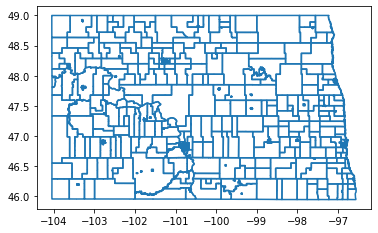

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['STATEFP', 'COUNTYFP', 'PRECINCT', 'G18USSRCRA', 'G18USSDHEI',
       'G18USSOWRI', 'G18HALRARM', 'G18HALDSCH', 'G18HALITUT', 'G18HALOWRI',
       'G18SOSDBOS', 'G18SOSICOA', 'G18SOSIJAE', 'G18SOSOWRI', 'G18ATGRSTE',
       'G18ATGDTHO', 'G18ATGOWRI', 'G18AGRRGOE', 'G18AGRDDOT', 'G18AGROWRI',
       'G18PSCRCHR', 'G18PSCDBRA', 'G18PSCOWRI', 'G18PSCRKRO', 'G18PSCDBUC',
       'G18PSCOWR2', 'G18TAXRRAU', 'G18TAXDOVE', 'G18TAXOWRI', 'geometry'],
      dtype='object')

## Loading, Combining Election Results
The SOS directed to this link for election results for the 2018 general: 
https://results.sos.nd.gov/ResultsSW.aspx?text=All&type=SW&map=CTY&eid=303

### U.S. Senator Election Results

In [7]:
# Import senator election results file
uss_18 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - Senator.xlsx")
counties = uss_18.sheet_names

# Create empty list to collect dataframes
df_uss = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(uss_18, sheet_name = county, usecols = [1,2,3,4], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_uss.append(df)
# Create the final dataframe 
combined_df_uss = pd.concat(df_uss)

# Rename the columns to match VEST
combined_df_uss.columns = ['County','Precinct','G18USSRCRA','G18USSDHEI','G18USSOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_uss = combined_df_uss[combined_df_uss["Precinct"]!="Precinct"]
combined_df_uss = combined_df_uss[combined_df_uss["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_uss = combined_df_uss.fillna(0)

# Deal with the index
combined_df_uss.reset_index(drop=True,inplace=True)

combined_df_uss.head()

,County,Precinct,G18USSRCRA,G18USSDHEI,G18USSOWRI
0,Adams,Adams County,796,364,4
1,Barnes,Precinct 2401-00,178,191,3
2,Barnes,Precinct 2402-00,292,382,4
3,Barnes,Precinct 2403-00,188,194,3
4,Barnes,Precinct 2404-00,284,317,3


### Representative in Congress Election Results

In [8]:
# Import house of representative election results file
hal_18 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - Representative.xlsx")
counties = hal_18.sheet_names

# Create empty list to collect dataframes
df_hal = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(hal_18, sheet_name = county, usecols = [1,2,3,4,5], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_hal.append(df)
# Create the final dataframe
combined_df_hal = pd.concat(df_hal)

# Rename the columns to match VEST
combined_df_hal.columns = ['County','Precinct', 'G18HALRARM','G18HALDSCH','G18HALITUT','G18HALOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_hal = combined_df_hal[combined_df_hal["Precinct"]!="Precinct"]
combined_df_hal = combined_df_hal[combined_df_hal["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_hal = combined_df_hal.fillna(0)

# Deal with the index
combined_df_hal.reset_index(drop=True,inplace=True)

combined_df_hal.head()

,County,Precinct,G18HALRARM,G18HALDSCH,G18HALITUT,G18HALOWRI
0,Adams,Adams County,878,236,44,0
1,Barnes,Precinct 2401-00,201,158,9,0
2,Barnes,Precinct 2402-00,313,314,37,1
3,Barnes,Precinct 2403-00,206,148,21,2
4,Barnes,Precinct 2404-00,306,267,29,1


### Secretary of State Election Results

In [9]:
# Import secretary of state election results file
sos_18 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - SOS.xlsx")
counties = sos_18.sheet_names

# Create empty list to collect dataframes
df_sos = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(sos_18, sheet_name = county, usecols = [1,2,3,4,5], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_sos.append(df)
# Create the final dataframe
combined_df_sos = pd.concat(df_sos)

# Rename the columns to match VEST
combined_df_sos.columns = ['County','Precinct', 'G18SOSDBOS','G18SOSICOA','G18SOSIJAE','G18SOSOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_sos = combined_df_sos[combined_df_sos["Precinct"]!="Precinct"]
combined_df_sos = combined_df_sos[combined_df_sos["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_sos = combined_df_sos.fillna(0)

# Deal with the index 
combined_df_sos.reset_index(drop=True,inplace=True)

combined_df_sos.head()

,County,Precinct,G18SOSDBOS,G18SOSICOA,G18SOSIJAE,G18SOSOWRI
0,Adams,Adams County,289,195,609,1
1,Barnes,Precinct 2401-00,165,40,144,0
2,Barnes,Precinct 2402-00,317,69,251,1
3,Barnes,Precinct 2403-00,166,33,161,1
4,Barnes,Precinct 2404-00,290,75,216,2


### Attorney General Election Results

In [10]:
# Import attorney general election results file
atg_18 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - Attorney.xlsx")
counties = atg_18.sheet_names

# Create empty list to collect dataframes
df_atg = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(atg_18, sheet_name = county, usecols = [1,2,3,4], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_atg.append(df)
# Create the final dataframe 
combined_df_atg = pd.concat(df_atg)

# Rename the columns to match VEST
combined_df_atg.columns = ['County','Precinct','G18ATGRSTE','G18ATGDTHO','G18ATGOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_atg = combined_df_atg[combined_df_atg["Precinct"]!="Precinct"]
combined_df_atg = combined_df_atg[combined_df_atg["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_atg = combined_df_atg.fillna(0)

# Deal with the index
combined_df_atg.reset_index(drop=True,inplace=True)

combined_df_atg.head()

,County,Precinct,G18ATGRSTE,G18ATGDTHO,G18ATGOWRI
0,Adams,Adams County,934,217,4
1,Barnes,Precinct 2401-00,254,109,0
2,Barnes,Precinct 2402-00,363,298,1
3,Barnes,Precinct 2403-00,236,136,1
4,Barnes,Precinct 2404-00,364,232,0


### Agriculture Commissioner Election Results 

In [11]:
# Import agriculture commissioner election results file
agr_18 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - Agriculture.xlsx")
counties = agr_18.sheet_names

# Create empty list to collect dataframes
df_agr = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(agr_18, sheet_name = county, usecols = [1,2,3,4], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_agr.append(df)
# Create the final dataframe 
combined_df_agr = pd.concat(df_agr)

# Rename the columns to match VEST
combined_df_agr.columns = ['County','Precinct','G18AGRRGOE','G18AGRDDOT','G18AGROWRI']    

# Remove the rows with column names and rows with total votes
combined_df_agr = combined_df_agr[combined_df_agr["Precinct"]!="Precinct"]
combined_df_agr = combined_df_agr[combined_df_agr["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_agr = combined_df_agr.fillna(0)

# Deal with the index
combined_df_agr.reset_index(drop=True,inplace=True)

combined_df_agr.head()

,County,Precinct,G18AGRRGOE,G18AGRDDOT,G18AGROWRI
0,Adams,Adams County,934,208,0
1,Barnes,Precinct 2401-00,237,124,0
2,Barnes,Precinct 2402-00,387,272,2
3,Barnes,Precinct 2403-00,222,146,2
4,Barnes,Precinct 2404-00,361,229,1


### Public Service Commissioner Election Results

In [12]:
# Import public service commissioner election results file
psc_18 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - PSC.xlsx")
counties = psc_18.sheet_names

# Create empty list to collect dataframes
df_psc = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(psc_18, sheet_name = county, usecols = [1,2,3,4], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_psc.append(df)
# Create the final dataframe 
combined_df_psc = pd.concat(df_psc)

# Rename the columns to match VEST
combined_df_psc.columns = ['County','Precinct','G18PSCRCHR','G18PSCDBRA','G18PSCOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_psc = combined_df_psc[combined_df_psc["Precinct"]!="Precinct"]
combined_df_psc = combined_df_psc[combined_df_psc["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_psc = combined_df_psc.fillna(0)

# Deal with the index
combined_df_psc.reset_index(drop=True,inplace=True)

combined_df_psc.head()

,County,Precinct,G18PSCRCHR,G18PSCDBRA,G18PSCOWRI
0,Adams,Adams County,888,248,1
1,Barnes,Precinct 2401-00,203,155,0
2,Barnes,Precinct 2402-00,309,335,1
3,Barnes,Precinct 2403-00,195,167,2
4,Barnes,Precinct 2404-00,304,286,1


### Public Service Commissioner (Unexpired 2-Year Term) Election Results

In [13]:
# Import 2 year term publice service commissioner election results file
psc2_18 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - PSC2.xlsx")
counties = psc2_18.sheet_names

# Create empty list to collect dataframes
df_psc2 = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(psc2_18, sheet_name = county, usecols = [1,2,3,4], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_psc2.append(df)
# Create the final dataframe 
combined_df_psc2 = pd.concat(df_psc2)

# Rename the columns to match VEST
combined_df_psc2.columns = ['County','Precinct','G18PSCRKRO','G18PSCDBUC','G18PSCOWR2']    

# Remove the rows with column names and rows with total votes
combined_df_psc2 = combined_df_psc2[combined_df_psc2["Precinct"]!="Precinct"]
combined_df_psc2 = combined_df_psc2[combined_df_psc2["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_psc2 = combined_df_psc2.fillna(0)

# Deal with the index
combined_df_psc2.reset_index(drop=True,inplace=True)

combined_df_psc2.head()

,County,Precinct,G18PSCRKRO,G18PSCDBUC,G18PSCOWR2
0,Adams,Adams County,812,297,0
1,Barnes,Precinct 2401-00,199,155,0
2,Barnes,Precinct 2402-00,319,307,4
3,Barnes,Precinct 2403-00,195,168,2
4,Barnes,Precinct 2404-00,319,260,0


### Tax Commissioner Election Results

In [14]:
# Import tax commissioner election results file
tax_18 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - Tax.xlsx")
counties = tax_18.sheet_names

# Create empty list to collect dataframes
df_tax = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(tax_18, sheet_name = county, usecols = [1,2,3,4], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_tax.append(df)
# Create the final dataframe 
combined_df_tax = pd.concat(df_tax)

# Rename the columns to match VEST
combined_df_tax.columns = ['County','Precinct','G18TAXRRAU','G18TAXDOVE','G18TAXOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_tax = combined_df_tax[combined_df_tax["Precinct"]!="Precinct"]
combined_df_tax = combined_df_tax[combined_df_tax["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_tax = combined_df_tax.fillna(0)

# Deal with the index
combined_df_tax.reset_index(drop=True,inplace=True)

combined_df_tax.head()

,County,Precinct,G18TAXRRAU,G18TAXDOVE,G18TAXOWRI
0,Adams,Adams County,834,297,2
1,Barnes,Precinct 2401-00,193,164,1
2,Barnes,Precinct 2402-00,306,333,2
3,Barnes,Precinct 2403-00,183,186,1
4,Barnes,Precinct 2404-00,300,286,1


### Combine Results

In [15]:
# Concatenate all dataframes
nd_18 = pd.concat([combined_df_uss,combined_df_hal,combined_df_sos,combined_df_atg,combined_df_agr,combined_df_psc,combined_df_psc2,combined_df_tax],axis=1)

# Drop repeated columns - County and Precinct
nd_18 = nd_18.loc[:,~nd_18.columns.duplicated()]

In [16]:
nd_18.columns

Index(['County', 'Precinct', 'G18USSRCRA', 'G18USSDHEI', 'G18USSOWRI',
       'G18HALRARM', 'G18HALDSCH', 'G18HALITUT', 'G18HALOWRI', 'G18SOSDBOS',
       'G18SOSICOA', 'G18SOSIJAE', 'G18SOSOWRI', 'G18ATGRSTE', 'G18ATGDTHO',
       'G18ATGOWRI', 'G18AGRRGOE', 'G18AGRDDOT', 'G18AGROWRI', 'G18PSCRCHR',
       'G18PSCDBRA', 'G18PSCOWRI', 'G18PSCRKRO', 'G18PSCDBUC', 'G18PSCOWR2',
       'G18TAXRRAU', 'G18TAXDOVE', 'G18TAXOWRI'],
      dtype='object')

## Validating Election Results

### Check Statewide Candidate Totals

In [17]:
data_columns = ['G18USSRCRA', 'G18USSDHEI', 'G18USSOWRI',
       'G18HALRARM', 'G18HALDSCH', 'G18HALITUT', 'G18HALOWRI', 'G18SOSDBOS',
       'G18SOSICOA', 'G18SOSIJAE', 'G18SOSOWRI', 'G18ATGRSTE', 'G18ATGDTHO',
       'G18ATGOWRI', 'G18AGRRGOE', 'G18AGRDDOT', 'G18AGROWRI', 'G18PSCRCHR',
       'G18PSCDBRA', 'G18PSCOWRI', 'G18PSCRKRO', 'G18PSCDBUC', 'G18PSCOWR2',
       'G18TAXRRAU', 'G18TAXDOVE', 'G18TAXOWRI']

print("Printing differences below")
for race in data_columns:
    if (sum(vest_shp[race])- nd_18[race].sum() != 0):
        print(race+" has a difference of "+str(sum(vest_shp[race])-nd_18[race].sum())+" votes")
        print("\tVEST: "+str(sum(vest_shp[race]))+" votes")
        print("\tSOURCES: "+str(nd_18[race].sum())+" votes")
    else:
        print(race + " is equal", "\tVEST: " + str(sum(vest_shp[race])), "\tRDH: " + str(nd_18[race].sum()))
print("")
print("All other races are equal")

Printing differences below
G18USSRCRA is equal 	VEST: 179720 	RDH: 179720
G18USSDHEI is equal 	VEST: 144376 	RDH: 144376
G18USSOWRI is equal 	VEST: 2042 	RDH: 2042
G18HALRARM is equal 	VEST: 193568 	RDH: 193568
G18HALDSCH is equal 	VEST: 114377 	RDH: 114377
G18HALITUT is equal 	VEST: 13066 	RDH: 13066
G18HALOWRI is equal 	VEST: 521 	RDH: 521
G18SOSDBOS is equal 	VEST: 120475 	RDH: 120475
G18SOSICOA is equal 	VEST: 40590 	RDH: 40590
G18SOSIJAE is equal 	VEST: 145275 	RDH: 145275
G18SOSOWRI is equal 	VEST: 937 	RDH: 937
G18ATGRSTE is equal 	VEST: 215633 	RDH: 215633
G18ATGDTHO is equal 	VEST: 102869 	RDH: 102869
G18ATGOWRI is equal 	VEST: 715 	RDH: 715
G18AGRRGOE is equal 	VEST: 213689 	RDH: 213689
G18AGRDDOT is equal 	VEST: 100914 	RDH: 100914
G18AGROWRI is equal 	VEST: 656 	RDH: 656
G18PSCRCHR is equal 	VEST: 190792 	RDH: 190792
G18PSCDBRA is equal 	VEST: 118122 	RDH: 118122
G18PSCOWRI is equal 	VEST: 650 	RDH: 650
G18PSCRKRO is equal 	VEST: 187939 	RDH: 187939
G18PSCDBUC is equal 	VES

### Check County Totals

#### County FIPs Data

In [18]:
# Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="North Dakota"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

# Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

# Create the dictionary
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# Modify county names in dataframe to match the FIPs file
county_name_changes_dict = {"LaMoure":"Lamoure","McKenzie":"Mckenzie","McLean":"Mclean"}
nd_18["County"] = nd_18["County"].map(county_name_changes_dict).fillna(nd_18["County"])

# Use the dictionary to go from a county name to a county FIPS
nd_18["County"] = nd_18["County"].map(fips_dict).fillna(nd_18["County"])

# Check the number of counties - looking for 53
print(len(nd_18["County"].unique()))

53


#### Check County Totals

In [19]:
print("Counties with differences printed below:")
diff_counties=[]
for i in data_columns:
    diff = vest_shp.groupby(['COUNTYFP']).sum()[i]-nd_18.groupby(["County"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:

All other races in all counties are equal


### Check Precinct Totals

#### Create a 'join_col' in Both Files

In [20]:
vest_shp.head(10)

,STATEFP,COUNTYFP,PRECINCT,G18USSRCRA,G18USSDHEI,G18USSOWRI,G18HALRARM,G18HALDSCH,G18HALITUT,G18HALOWRI,...,G18PSCRCHR,G18PSCDBRA,G18PSCOWRI,G18PSCRKRO,G18PSCDBUC,G18PSCOWR2,G18TAXRRAU,G18TAXDOVE,G18TAXOWRI,geometry
0,38,021,Precinct 03,572,555,3,656,443,23,1,...,665,422,0,654,433,0,634,468,0,"POLYGON ((-98.38230 45.93720, -98.38227 45.938..."
1,38,021,Precinct 01,600,288,0,625,222,35,0,...,633,235,0,621,235,0,597,272,0,"POLYGON ((-99.00566 45.94540, -99.00561 45.948..."
2,38,021,Precinct 02,81,68,3,94,53,2,0,...,91,51,0,86,52,0,83,59,0,"POLYGON ((-98.50696 45.93990, -98.50683 45.945..."
3,38,043,Steele,437,164,2,478,94,29,1,...,440,140,0,435,142,0,419,170,1,"POLYGON ((-100.11463 46.98511, -100.11463 46.9..."
4,38,043,Tuttle,74,44,2,76,36,5,0,...,79,39,0,76,40,1,66,50,0,"POLYGON ((-100.11444 47.06968, -100.11440 47.0..."
5,38,043,Tappen,214,54,1,224,30,15,0,...,224,42,0,215,41,0,221,43,0,"POLYGON ((-99.73456 47.01191, -99.73454 47.012..."
6,38,043,Dawson,104,25,0,115,16,4,0,...,114,20,0,113,17,0,117,15,0,"POLYGON ((-99.86198 47.06785, -99.85810 47.067..."
7,38,043,Robinson,46,37,0,52,29,1,0,...,49,29,0,48,31,0,50,31,0,"POLYGON ((-99.86326 47.23069, -99.86326 47.235..."
8,38,043,Pettibone,36,40,0,44,30,2,0,...,44,31,0,41,29,0,42,31,0,"POLYGON ((-99.60847 47.15326, -99.60847 47.154..."
9,38,083,Precinct 01,607,179,3,635,115,37,1,...,614,154,2,608,156,0,608,159,0,"POLYGON ((-100.67335 47.33312, -100.67334 47.3..."


In [21]:
# Create a VEST join col
vest_shp["join_col"] = vest_shp["COUNTYFP"]+"-"+vest_shp["PRECINCT"]
# Check to make sure it is unique
print(vest_shp["join_col"].value_counts(dropna=False))

# Create an election results join col
nd_18["join_col"] = nd_18["County"]+"-"+nd_18["Precinct"]
# Check to make sure it is unique
print(nd_18["join_col"].value_counts(dropna=False))

021-Precinct 03                       1
065-Precinct 04-Fort Clark            1
081-Gwinner #2                        1
081-Rutland-Cayuga #5                 1
081-Cogswell #3                       1
                                     ..
017-4504 Argusville Fire Hall         1
017-2402 Alice Quality Seed Office    1
017-2202 Arthur Community Hall        1
017-2207 Davenport Community Ctr      1
009-Precinct 01                       1
Name: join_col, Length: 424, dtype: int64
001-Adams County                 1
069-Precinct 06 -2ND WARD        1
069-Precinct 04- 1ST WARD 1ST    1
069-Precinct 03                  1
069-Precinct 02                  1
                                ..
029-Precinct 3                   1
029-Precinct 2                   1
029-Precinct 1                   1
027-Precinct 02                  1
105-Precinct 76                  1
Name: join_col, Length: 424, dtype: int64


#### Join Attempt #1

In [22]:
join_attempt_one = pd.merge(vest_shp,nd_18,how="outer",on="join_col",indicator=True)
join_attempt_one["_merge"].value_counts()

both          410
left_only      14
right_only     14
Name: _merge, dtype: int64

In [23]:
# Change Names to Perform Join
election_vest_id_changes_dict = {'037-New Leipzig ': '037-New Leipzig', '047-Precinct 01- American Legion ': '047-Precinct 01 - American Legion', '047-Precinct 02-American Legion': '047-Precinct 02 - American Legion', '047-Precinct 04 -Lehr Com Cent.': '047-Precinct 04 - Lehr Com Cent.', '065-Precinct 02-Center /West Side': '065-Precinct 02-Center/West Side', '069-Precinct 04- 1ST WARD 1ST': '069-Precinct 04 - 1ST WARD 1ST', '069-Precinct 05- 1ST WARD 2ND': '069-Precinct 05 - 1ST WARD 2ND', '069-Precinct 06 -2ND WARD': '069-Precinct 06 - 2ND WARD', '069-Precinct 07-3RD WARD': '069-Precinct 07 - 3RD WARD', '079- Rolla #1': '079-Rolla #1', '099-Precinct 2 -District 10': '099-Precinct 2 - District 10', '101-Afton Our Redeemers ': '101-Afton Our Redeemers', '101-North Central  ': '101-North Central', '101-Ruthville  ': '101-Ruthville'}
nd_18["join_col"] = nd_18["join_col"].map(election_vest_id_changes_dict).fillna(nd_18["join_col"])

#### Join Attempt #2

In [24]:
join_attempt_two = pd.merge(vest_shp,nd_18,how='outer',on="join_col",indicator="final_merge")
print(join_attempt_two["final_merge"].value_counts())

both          424
left_only       0
right_only      0
Name: final_merge, dtype: int64


#### Check Results Precinct-by-Precinct 

In [25]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["unique_ID"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["unique_ID"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["unique_ID"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [26]:
validater_row(join_attempt_two[join_attempt_two["final_merge"]=="both"],data_columns)


There are  424  total rows
0  of these rows have election result differences
424  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]
